# Машинное обучение, ФКН ВШЭ

# Практическое задание 10. Обучение без учителя.

## Общая информация
Дата выдачи: 23.03.2022

Мягкий дедлайн: 06.04.2022 23:59 MSK

Жёсткий дедлайн: 10.04.2022 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к географическим и текстовым данным. Также мы подробно остановимся на тематическом моделировании текстов, задаче обучения представлений и в каком-то смысле поработаем с semi-supervised learning. 



In [3]:
import pandas as pd
import numpy as np

np.random.seed(0xFFFFFFF)

**Задание 0 (1e-100 балла)**. Опишите свои ощущения от домашки по ЕМ-алгоритму (можно картинкой или мемом).

In [ ]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻

## Часть 1. Кластеризация автобусных остановок

В этом задании мы сравним разные алгоритмы кластеризации для данных об автобусных остановках Москвы.

**Задание 1.1 (1 балл).** Реализуйте алгоритм спектральной кластеризации, который упоминался на лекции. Для этого разберитесь с кодом шаблона, данного ниже, и допишите недостающую функцию. Напомним, что для графа с матрицей смежности $W = \{w_{ij}\}_{i, j = 1 \dots \ell}$ лапласиан определяется как:

$$
L = D - W,
$$

где $D = \text{diag}(d_1, ..., d_{\ell}), d_i = \sum_{j=1}^{\ell} w_{ij}$.

In [4]:
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans


class GraphClustering(ClusterMixin):
    def __init__(self, n_clusters=8, n_components=None, **kwargs):
        '''
        Spectral clustering algorithm
        param n_clusters: number of clusters to form
        param n_components: number of eigenvectors to use
        '''

        if n_components is None:
            n_components = n_clusters

        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit_predict(self, X, y=None):
        '''
        Perform spectral clustering from graph adjacency matrix
        and return vertex labels.
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, ) - vertex labels
        '''

        eigenvectors = self._generate_eigenvectors(X)
        labels = self.kmeans.fit_predict(eigenvectors[:, 1:])
        return labels

    def _generate_eigenvectors(self, X):
        '''
        Compute eigenvectors for spectral clustering
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, n_components) - eigenvectors
        '''

        D = np.diag(np.sum(X, axis=1))
        L = D - X
        vals, vecs = np.linalg.eig(L)
        
        ind = np.abs(np.real(vals)) < 1e-9
        
        return np.real(vecs[:, ind])

Перед тем, как переходить к следующему заданию, протестируйте свое решение.

In [5]:
n_blocks, n_vertices = 10, 1000
block_vertices = n_vertices // n_blocks

X = np.zeros((n_vertices, n_vertices))
for i in range(0, n_vertices, block_vertices):
    X[i:i + block_vertices, i:i + block_vertices] = np.sqrt(i + 1)

graph_clustering = GraphClustering(n_clusters=n_blocks)
labels = graph_clustering.fit_predict(X)

true_labels = np.zeros(n_vertices, dtype=np.int32)
for i in range(0, n_vertices, block_vertices):
    true_labels[i:i + block_vertices] = labels[i]

assert labels.shape == (n_vertices, )
assert np.all(np.bincount(labels) == np.full(n_blocks, block_vertices))
assert np.all(labels == true_labels)

Теперь можем приступить к работе с реальными данными. Скачайте файл с данными об остановках общественного транспорта **в формате .xlsx** по [ссылке](https://data.mos.ru/opendata/download/60464/1/201) (так гарантированно не возникнет проблем с парсингом файла) и загрузите таблицу в ноутбук. Если вдруг сайт Правительства Москвы сойдет с ума, то возьмите какую-нибудь версию данных [отсюда](https://data.mos.ru/opendata/7704786030-city-surface-public-transport-stops). Для удобства визуализации мы будем работать только с остановками в ЦАО.

In [9]:
pip install openpyxl

     |████████████████████████████████| 242 kB 249 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [10]:
data = pd.read_excel('../input/clustering-data/City surface public transport stops.xlsx')
data = data[data.AdmArea_en == "Czentral`ny'j administrativny'j okrug"]
data = data.reset_index()
data.head()

index  ID_en                                            Name_en  \
0    278    347       «2-й Лесной пер.», улица Бутырский Вал (347)   
1    279    349    «Ул. Сущевский Вал», Новослободская улица (349)   
2    355    479  «Стадион Лужники (южн.) (пос.)», улица Лужники...   
3    356    480      «Спортзал Дружба», Лужнецкая набережная (480)   
4    357    481       «Лужнецкая наб.», Лужнецкая набережная (481)   

   Longitude_WGS84_en  Latitude_WGS84_en             Street_en  \
0           37.586584          55.782106   улица Бутырский Вал   
1           37.590714          55.790630  Новослободская улица   
2           37.565972          55.714265         улица Лужники   
3           37.570191          55.712504  Лужнецкая набережная   
4           37.574559          55.713770  Лужнецкая набережная   

                              AdmArea_en      District_en  \
0  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
1  Czentral`ny'j administrativny'j okrug   Tverskoj rajon   
2  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
3  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   
4  Czentral`ny'j administrativny'j okrug  rajon Xamovniki   

                          RouteNumbers_en                 StationName_en  \
0                   АТ18; А12; АТ56; АТ78                2-й Лесной пер.   
1             АТ47; АМ10; АТ3; АТ56; АТ78              Ул. Сущевский Вал   
2  А64; А216; А809; АС12; А255; АБК; АТ79  Стадион Лужники (южн.) (пос.)   
3  А64; А216; А809; АС12; А255; АБК; АТ79                Спортзал Дружба   
4  А64; А216; А809; АС12; А255; АБК; АТ79                 Лужнецкая наб.   

   Direction_en Pavilion_en OperatingOrgName_en EntryState_en  global_id  \
0           NaN          да   ГУП «Мосгортранс»        active  889085436   
1           NaN          да   ГУП «Мосгортранс»        active  889085437   
2           NaN          да   ГУП «Мосгортранс»        active  889085549   
3           NaN          да   ГУП «Мосгортранс»        active  889085550   
4           NaN          да   ГУП «Мосгортранс»        active  889085551   

   geoData  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

Воспользуемся библиотекой `folium` для визуализации данных.

In [11]:
import folium

map = folium.Map([55.75215, 37.61819], zoom_start=12)
for id, row in data.iterrows():
    folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=10).add_to(map)
map

**Задание 1.2 (1 балл).** Попробуем построить граф, в котором вершинами будут остановки. Как вы уже могли заметить, для каждой остановки указаны номера маршрутов, проходящих через неё. Логично соединить ребрами соседние остановки каждого маршрута. Однако мы не знаем, в каком порядке автобусы объезжают остановки. Но мы можем применить эвристический алгоритм, который восстановит нам порядок маршрутов:

* Для каждого маршрута выделим список всех остановок, через которые он проходит.
* Выберем начальную остановку маршрута как точку, наиболее удаленную от всех остальных остановок этого маршрута.
* Каждую следующую точку маршрута будем выбирать как самую близкую из оставшихся точек (не включенных в маршрут ранее).

Фактически, у нас получается жадное решение задачи коммивояжера. Когда мы отсортировали маршруты, можем построить по ним граф. Будем строить его по таким правилам:

* Между двумя остановками будет ребро, если они являются соседними хотя бы на одном маршруте. Вес ребра равен числу маршрутов, на которых остановки являются соседними.
* В графе не будет петель (то есть у матрицы смежности будет нулевая диагональ).

Реализуйте предложенный способ построения графа. Для этого рекомендуется воспользоваться шаблонами, приведенными ниже.

In [91]:
def get_routes(data, position=False):
    '''
    Accumulate routes from raw data
    param data: pd.DataFrame - public transport stops data
    return: dict - unsorted stops ids for each route,
                   e.g. routes['A1'] = [356, 641, 190]
    '''

    route_numbers = data['RouteNumbers_en'].apply(lambda x: x.replace(';', '').split())
    
    row = 0
    routes_position = dict()
    
    index_col = list(range(1037))
    
    stop_position = list(zip(index_col, list(zip(data['Longitude_WGS84_en'], data['Latitude_WGS84_en']))))

    for route_list in route_numbers:
        for key in route_list:
        
            if key not in routes_position:
                routes_position[key] = []

            routes_position[key].append(stop_position[row])
            
        row += 1
    
    return routes_position


def sort_routes(data, routes_position):
    '''
    Sort routes according to the proposed algorithm
    param data: pd.DataFrame - public transport stops data
    param routes: dict - unsorted stops ids for each route
    return: dict - sorted stops ids for each route
    '''
    
    sorted_routes = dict()
    
    for route in routes_position:
        final_dist = dict()
        sorted_dist = []
        
        position = np.array(routes_position[route], dtype='object')[:, 1]
        position = np.array([list(i) for i in position]) 

        distances = np.sum((position[np.newaxis, :, :] - position[:, np.newaxis, :]) ** 2, axis=2)
        dist_sum = np.sum(distances, axis=1)

        point = np.argmax(dist_sum)
        flag = [False] * len(distances)
        sorted_dist.append(np.array(routes_position[route], dtype='object')[:, 0][point])

        for it in range(len(distances)):
            flag[point] = True
            point = np.argmin(np.where(flag, 1000, distances[point]))
            sorted_dist.append(np.array(routes_position[route], dtype='object')[:, 0][point])
        
        sorted_routes[route] = sorted_dist
        
    
    return sorted_routes



def get_adjacency_matrix(data, sorted_routes):
    '''
    Compute adjacency matrix for sorted routes
    param data: pd.DataFrame - public transport stops data
    param sorted_routes: dict - sorted stops ids for each route
    return: (n_samples, n_samples) - graph adjacency matrix
    '''
    adjacency_matrix = np.zeros((len(data['RouteNumbers_en']), 
                                 len(data['RouteNumbers_en'])))
    
    for routes in sorted_routes:
    
        size = len(sorted_routes[routes])
        if size > 1:
            
            flatten = np.repeat(sorted_routes[routes], 2)
            
            vert = np.array_split(np.delete(flatten, [0, -1]), size - 1)
            hor = np.array_split(np.delete(flatten[::-1], [0, -1]), size - 1)
            
            for i in [vert, hor]:
                adjacency_matrix[np.array(i)[:, 0], np.array(i)[:,1]] += 1
            
    return adjacency_matrix

In [92]:
routes = get_routes(data, position=True)
sorted_routes = sort_routes(data, routes)
adjacency_matrix = get_adjacency_matrix(data, sorted_routes)

In [93]:
adjacency_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Проверим, что маршруты получились адекватными. Для этого нарисуем их на карте.

In [14]:
map = folium.Map([55.75215, 37.61819], zoom_start=12)
for route_id in np.random.choice(list(sorted_routes.keys()), size=5):
    coords = data.loc[
        sorted_routes[route_id],
        ['Latitude_WGS84_en', 'Longitude_WGS84_en']
    ].values.tolist()
    folium.vector_layers.PolyLine(coords).add_to(map)

map

**Задание 1.3 (0 баллов)**. Реализуйте функцию `draw_clustered_map`, которая рисует карту центра Москвы с кластерами остановок, раскрашенными в разные цвета.

source: https://www.kaggle.com/code/lucaspcarlini/clustering-and-visualisation-using-folium-maps/notebook


In [15]:
def draw_clustered_map(data, labels):
    '''
    Create map with coloured clusters
    param data: pd.DataFrame - public transport stops data
    param labels: (n_samples, ) - cluster labels for each stop
    return: folium.Map - map with coloured clusters
    '''

    map_clusters = folium.Map([55.75215, 37.61819], zoom_start=12)

    x = np.arange(len(np.unique(labels)))
    ys = [i + x + (i*x)**2 for i in range(len(np.unique(labels)))]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    for lat, lng, cluster in zip(data['Latitude_WGS84_en'], 
                                 data['Longitude_WGS84_en'],
                                 labels):
        
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=5,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.9).add_to(map_clusters)
       
    return map_clusters

**Задание 1.4 (1.5 балла)**. Примените алгоритмы кластеризации K-Means и DBSCAN из `sklearn` на координатах остановок, а также свою реализацию спектральной кластеризации на построенной выше матрице смежности. Визуализируйте результат кластеризации с помощью функции `draw_clustered_map`. Подберите параметры алгоритмов (`n_clusters` у K-Means, `eps` у DBSCAN, `n_clusters` и `n_components` у спектральной кластеризации) так, чтобы получить наиболее характерный для этих алгоритмов результат кластеризации (можете поэкспериментировать и оставить в ноутбуке картинки только для итоговых значений параметров, также обратите внимание на баланс объектов в кластерах). Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
X = np.array(data.loc[:, ['Longitude_WGS84_en', 'Latitude_WGS84_en']])

In [22]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)
labels_km = kmeans.labels_

In [23]:
draw_clustered_map(data, labels_km)

In [24]:
dbscan = DBSCAN(eps=0.0025).fit(X)
labels_db = dbscan.labels_

In [25]:
draw_clustered_map(data, labels_db)

In [96]:
graph_clustering = GraphClustering(n_clusters=5)
labels_sc = graph_clustering.fit_predict(adjacency_matrix)

In [97]:
draw_clustered_map(data, labels_sc)

Проинтерпретируйте полученные результаты. Чем отличаются разбиения на кластеры, получаемые разными алгоритмами? Какие плюсы и минусы есть у каждого алгоритма? Какой алгоритм кажется вам наиболее подходящим для кластеризации остановок?

**Ответ:** Из трех алгоритмов KMeans по ощущениям работает лучше (больше похоже на разбиение по маршрутам). В случае с DBSCAN и спектральной кластеризацией наблюдается дисбаланс классов

## Часть 2. Тематическое моделирование текстов

В этой части мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [26]:
data_txt = pd.read_csv('../input/bbcnewsarchive/bbc-news-data.csv', sep='\t')
data_txt

category filename                              title  \
0     business  001.txt  Ad sales boost Time Warner profit   
1     business  002.txt   Dollar gains on Greenspan speech   
2     business  003.txt  Yukos unit buyer faces loan claim   
3     business  004.txt  High fuel prices hit BA's profits   
4     business  005.txt  Pernod takeover talk lifts Domecq   
...        ...      ...                                ...   
2220      tech  397.txt   BT program to beat dialler scams   
2221      tech  398.txt    Spam e-mails tempt net shoppers   
2222      tech  399.txt            Be careful how you code   
2223      tech  400.txt    US cyber security chief resigns   
2224      tech  401.txt   Losing yourself in online gaming   

                                                content  
0      Quarterly profits at US media giant TimeWarne...  
1      The dollar has hit its highest level against ...  
2      The owners of embattled Russian oil giant Yuk...  
3      British Airways has blamed high fuel prices f...  
4      Shares in UK drinks and food firm Allied Dome...  
...                                                 ...  
2220   BT is introducing two initiatives to help bea...  
2221   Computer users across the world continue to i...  
2222   A new European directive could put software w...  
2223   The man making sure US computer networks are ...  
2224   Online role playing games are time-consuming,...  

[2225 rows x 4 columns]

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [27]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [28]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [30]:
data_txt['raw_text'] = data_txt.apply(lambda row: row.title + row.content, axis=1)
data_txt['text'] = data_txt.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [31]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

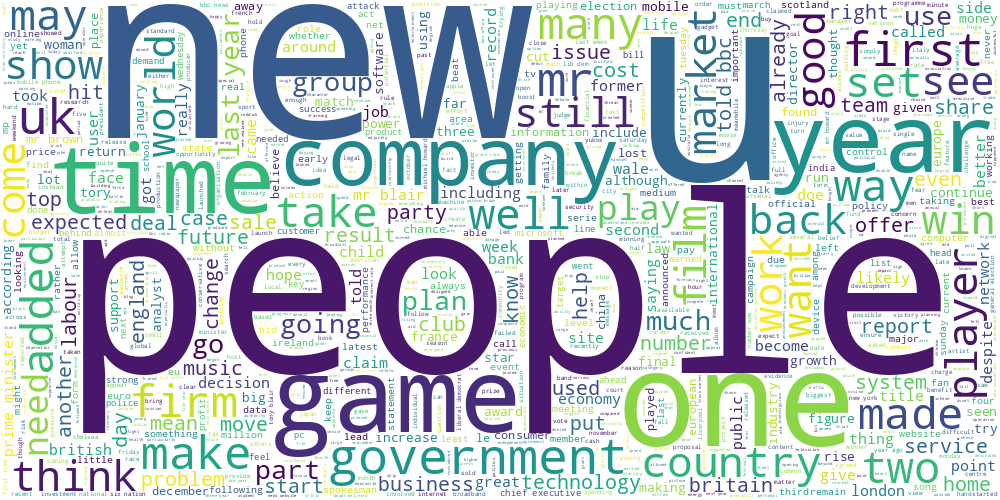

In [32]:
draw_wordcloud(data_txt.text)

**Задание 2.1 (1 балл).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:** Да, в основном, темы принадлежат к одному контексту (английские национальные игры, искусство и кино, экономка и финансы), который улавливается умозрительно

In [33]:
vectorizer = TfidfVectorizer(min_df=5)
X = vectorizer.fit_transform(data_txt.text)

In [34]:
km_model = KMeans(n_clusters=8, random_state=0).fit(X)

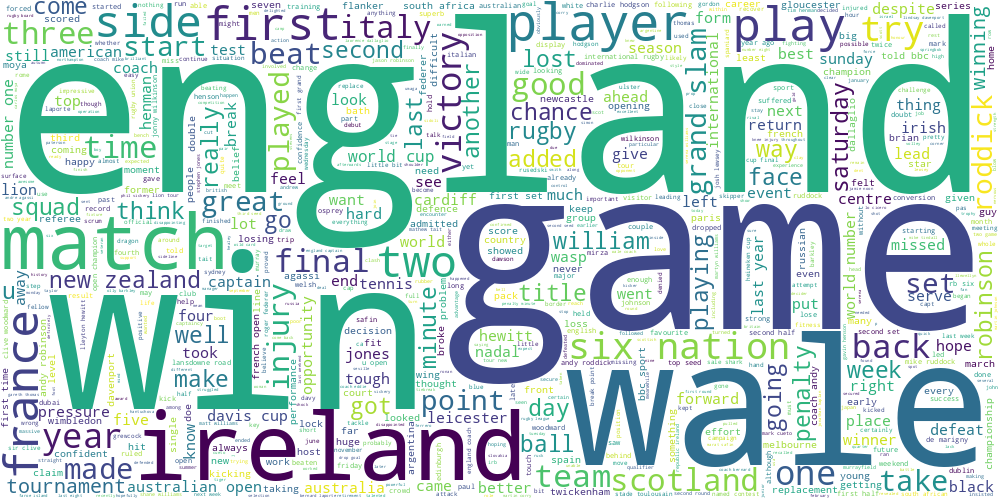

In [35]:
draw_wordcloud(data_txt.text[km_model.labels_ == 0])

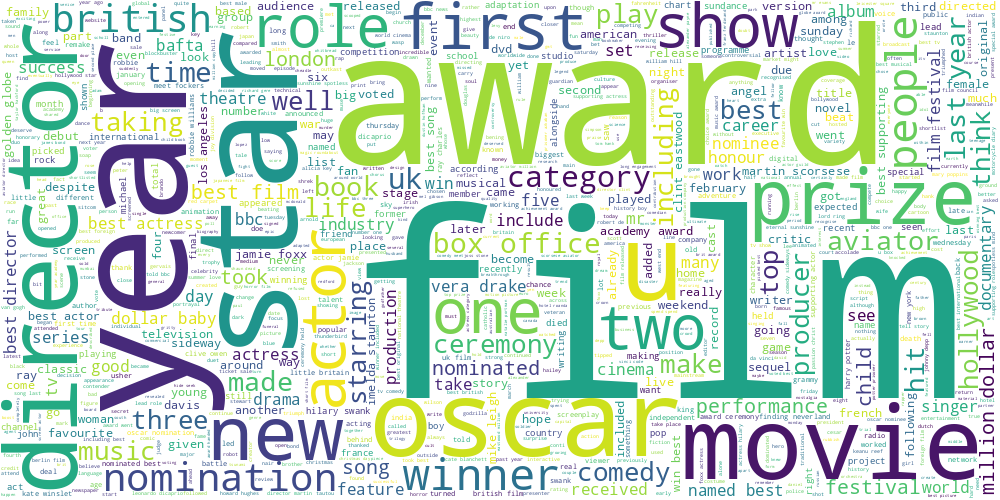

In [36]:
draw_wordcloud(data_txt.text[km_model.labels_ == 3])

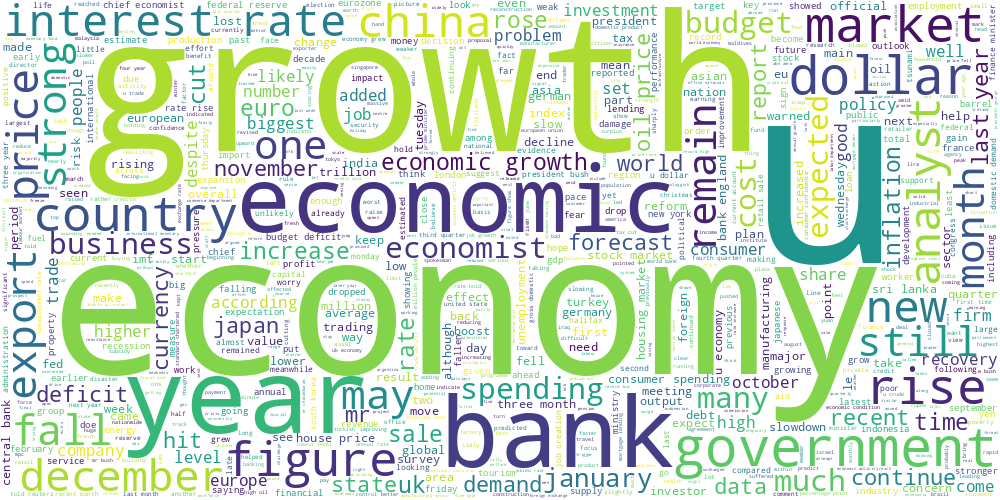

In [37]:
draw_wordcloud(data_txt.text[km_model.labels_ == 7])

**Задание 2.2 (0.5 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:** Да, полученные слова в точности согласуются с облаками тегов из прошлого задания

In [38]:
clust_centers = km_model.cluster_centers_.argsort()[:, ::-1]
features = vectorizer.get_feature_names()

for clust_no in [0, 3, 7]:
    print('cluster id', clust_no)
    for ind in clust_centers[clust_no, :15]:
        print(features[ind])
    print()

cluster id 0
england
game
match
wale
ireland
rugby
win
player
france
injury
open
williams
seed
robinson
cup

cluster id 3
film
award
best
oscar
actor
star
festival
actress
director
nomination
movie
comedy
year
prize
category

cluster id 7
economy
growth
rate
bank
economic
price
dollar
market
year
figure
rise
deficit
oil
export
spending



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Задание 2.3 (1.5 балла).** В первой части мы сравнили три разных алгоритма кластеризации на географических данных. Проделаем то же самое для текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов K-Means, DBSCAN и спектральной кластеризации (на этот раз воспользуйтесь реализацией из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [39]:
km_text = KMeans(n_clusters=8, random_state=0).fit(X)
labels_km = km_text.labels_

In [40]:
np.unique(labels_km)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [41]:
db_text = DBSCAN(eps=0.825).fit(X)
labels_db = db_text.labels_

In [42]:
np.unique(labels_db)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [43]:
sc_text = SpectralClustering(n_clusters=8, random_state=0).fit(X)
labels_sc = sc_text.labels_

In [44]:
np.unique(labels_sc)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [45]:
tsne = TSNE(n_components=2, perplexity=20, verbose=0).fit_transform(X)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [46]:
def scatter_plot(method):
    
    if method == 'Kmeans':
        labels = labels_km
    elif method == 'DBSCAN':
        labels = labels_db
    else:
        labels = labels_sc
    
    fig = plt.figure(figsize = (20, 10))
    ax = plt.axes()
    plt.scatter(tsne[:, 0], tsne[:, 1], marker = "x", c = labels)
    plt.title(method)
    plt.show()

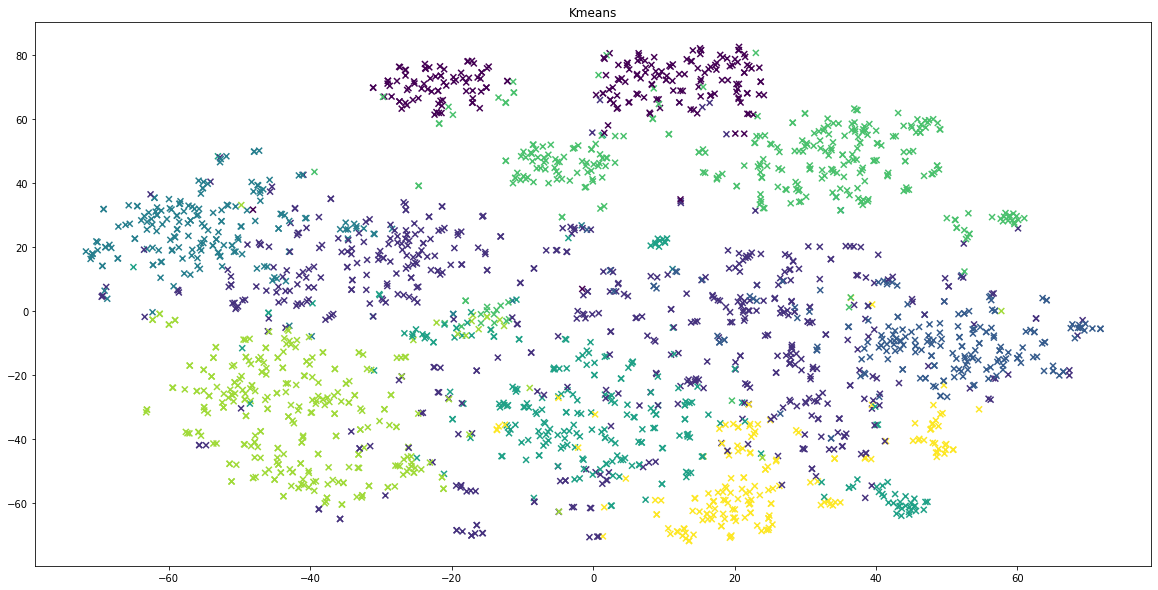

In [47]:
scatter_plot('Kmeans')

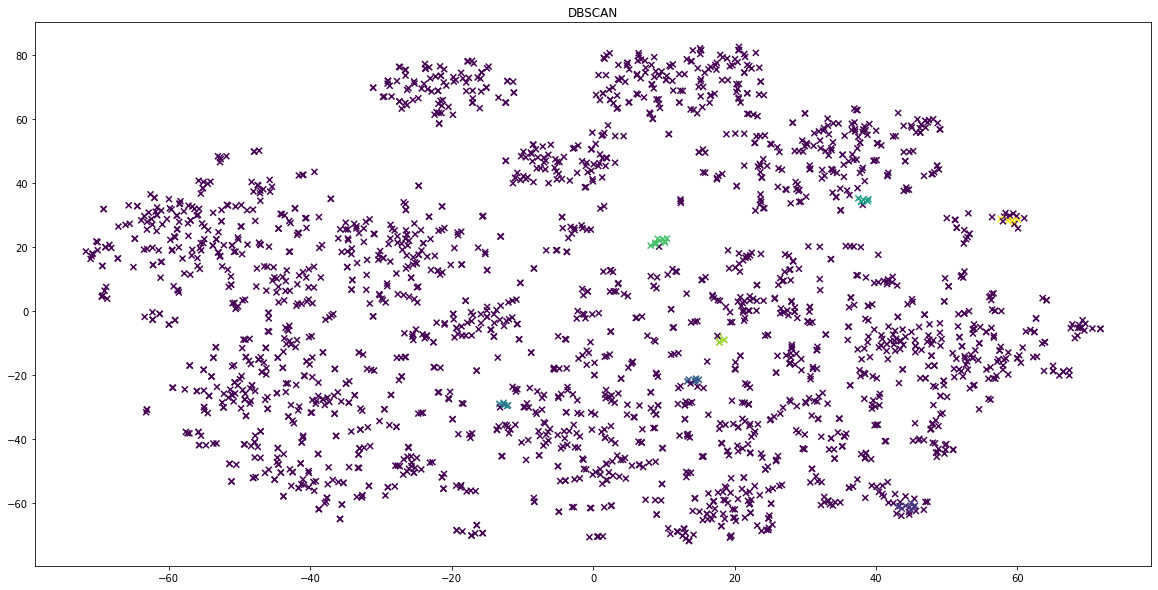

In [48]:
scatter_plot('DBSCAN')

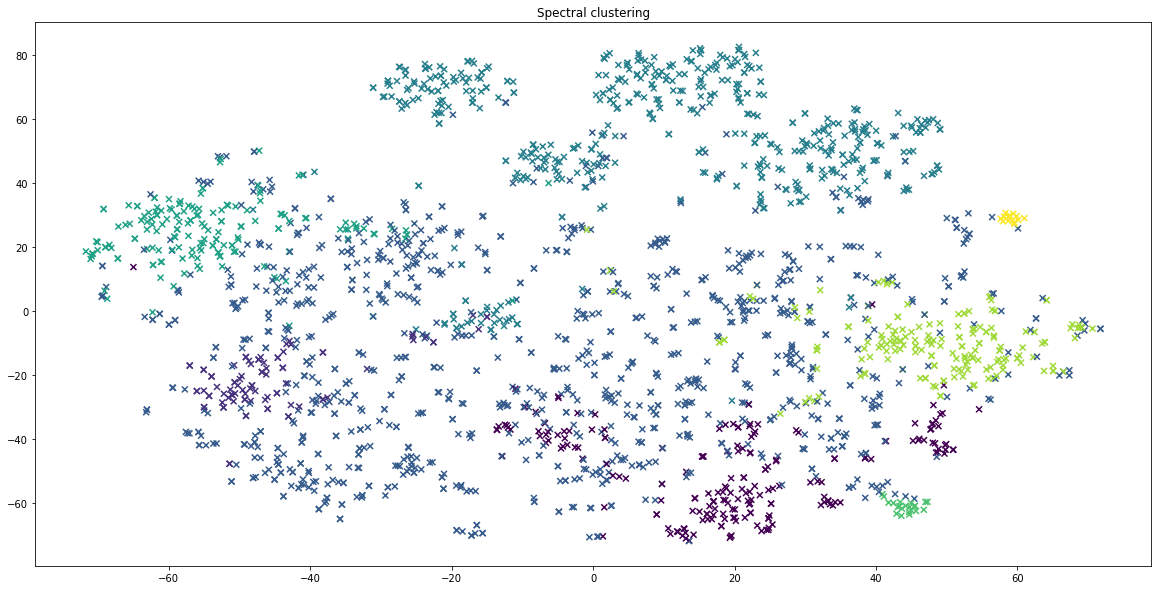

In [49]:
scatter_plot('Spectral clustering')

Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Соотносятся ли визуализации для текстов с визуализациями для географических данных?

**Ответ:**

Самым сбалансированным ожидаемо оказался Kmeans. DBSCAN почти все объекты отнес к outliers (поэтому ни о каком балансе речи не идет)

**Задание 2.4 (1.5 балла).** Обучите модель латентного размещения Дирихле. Не забудьте, что она работает с мешком слов, а не с tf-idf признаками. Придумайте, как превратить распределение тем для текста в номер его кластера. Возьмите параметр `n_components` в 2-3 раза больше, чем число кластеров для K-Means. Получились ли темы более узкими от такого нововведения? Постройте облака тегов для нескольких наиболее удачных тем.

**Ответ:** Да, стали. Они теперь приурочены к конкретному событию 

In [50]:
count_vectorizer = CountVectorizer().fit(data_txt.text)
tf = count_vectorizer.transform(data_txt.text)

In [51]:
lda = LatentDirichletAllocation(n_components=18, random_state=0)
lda_mat = lda.fit_transform(tf)
lda_components = lda.components_

source: https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/

In [61]:
terms = count_vectorizer.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:2000]
    top_terms_list=list(dict(top_terms_key).keys())

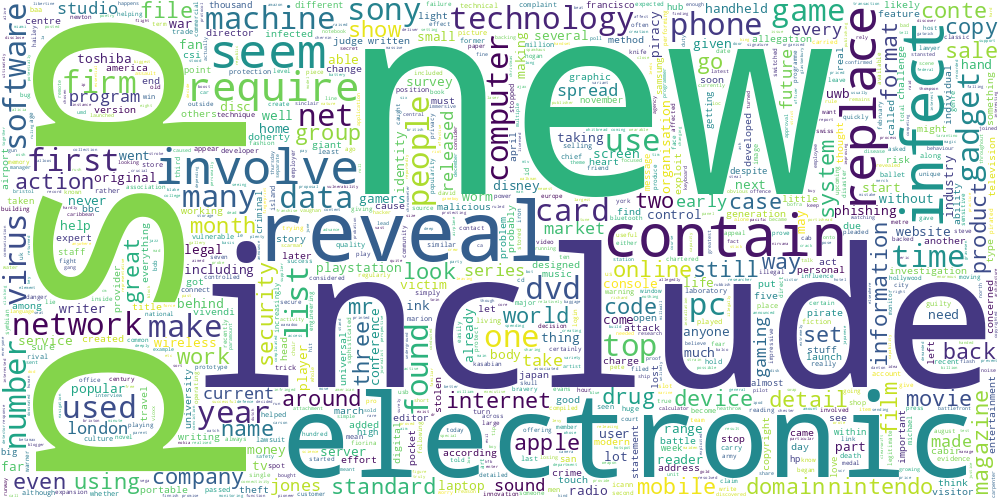

In [63]:
draw_wordcloud(top_terms_list)

## Часть 3. Transfer learning для задачи классификации текстов

**Задание 3.1 (0.5 балла).** Вспомним, что у нас есть разметка для тематик статей. Попробуем обучить классификатор поверх unsupervised-представлений для текстов. Рассмотрите три модели:

* Логистическая регрессия на tf-idf признаках
* K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
* Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

Разделите выборку на обучающую и тестовую, замерьте accuracy на обоих выборках для всех трех моделей. Параметры всех моделей возьмите равными значениям по умолчанию.

In [64]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
true_labels = le.fit_transform(data_txt.category)

In [65]:
true_labels

array([0, 0, 0, ..., 4, 4, 4])

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, true_labels, test_size=0.25, random_state=0)

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.9730700179533214

In [68]:
km_clf = KMeans(random_state=0).fit(X_train)
X_train_dist = km_clf.transform(X_train) ** 2
X_test_dist = km_clf.transform(X_test) ** 2

clf_km = LogisticRegression(random_state=0, max_iter=10000).fit(X_train_dist, y_train)
y_pred = clf_km.predict(X_test_dist)

accuracy_score(y_test, y_pred)

0.9102333931777379

In [69]:
lda = LatentDirichletAllocation(random_state=0)
X_lda = lda.fit_transform(tf)

X_train_lda, X_test_lda, y_train, y_test = train_test_split(X_lda, true_labels, test_size=0.25, random_state=0)

clf_lda = LogisticRegression(random_state=0, max_iter=5000).fit(X_train_lda, y_train)
y_pred = clf_lda.predict(X_test_lda)

accuracy_score(y_test, y_pred)

0.8850987432675045

У какой модели получилось лучшее качество? С чем это связано?

**Ответ:** Лучшее качество вышло у модели логистической регрессии на tf-idf. Это может быть связано с тем, что tf-idf сам по себе дает хорошее признаковое описание текста, в то время как для двух других моделей мы брали дефолтные параметры, что негативно могло сказаться на итоговом качестве

**Задание 3.2 (1.5 балла).** Теперь просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 5:65:30. Будем называть части, соответственно, размеченный трейн, неразмеченный трейн и валидация.

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всем трейне целиком (размеченном и неразмеченном, суммарно 70%), а итоговый классификатор обучайте только на размеченном трейне (5%). Подберите гиперпараметры моделей по качеству на валидации (30%), а затем оцените качество на тестовой выборке (которая осталась от прошлого задания). Не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации. 

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X, true_labels, test_size=0.3, random_state=0)

X_train_unl, X_train_labeled, y_train_unl, y_train_labeled = train_test_split(X_train, y_train, test_size=0.07, random_state=0)

In [71]:
n_clusters_grid = [5, 10, 20, 30, 50, 80]
C_grid = np.logspace(-4, 4, 8)
solver_grid = ['lbfgs', 'newton-cg']

In [72]:
max_acc = dict()

for n_clusters in n_clusters_grid:
    for C in C_grid:
        for solver in solver_grid:
            
            km_clf = KMeans(n_clusters=n_clusters, random_state=0).fit(X_train)
            X_val_dist = km_clf.transform(X_val) ** 2
            X_train_labeled_dist = km_clf.transform(X_train_labeled) ** 2

            clf_km = LogisticRegression(C=C, 
                                        solver=solver, 
                                        random_state=0).fit(X_train_labeled_dist, y_train_labeled)
            
            y_pred = clf_km.predict(X_val_dist)

            max_acc[(n_clusters, C, solver)] = accuracy_score(y_val, y_pred)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [76]:
max(max_acc, key=max_acc.get)

(80, 3.727593720314938, 'lbfgs')

In [78]:
km_clf = KMeans(n_clusters=80, random_state=0).fit(X_train)

X_test_dist = km_clf.transform(X_test) ** 2
X_train_labeled_dist = km_clf.transform(X_train_labeled) ** 2

clf_km = LogisticRegression(C=3.727593720314938, 
                            solver='lbfgs', 
                            random_state=0,
                            max_iter=10000).fit(X_train_labeled_dist, y_train_labeled)
            
y_pred = clf_km.predict(X_test_dist)

accuracy_score(y_test, y_pred)

0.947935368043088

Как изменились результаты по сравнению с обучением на полной разметке? Сделайте выводы.

**Ответ:** Хоть мы и обучались лишь на части данных, подбор гиперпараметров для kmeans+logreg показал более высокое качество

## Бонус

**Задание 4 (1 балл)**. Разберитесь с semi-supervised методами, которые реализованы в `sklearn` и примените их к заданию 3.2. Получилось ли добиться лучшего качества? Сделайте выводы.

In [ ]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC

random_unlabeled_points = rng.rand(iris.target.shape[0]) < 0.3
iris.target[random_unlabeled_points] = -1
svc = SVC(probability=True, gamma="auto")
self_training_model = SelfTrainingClassifier(svc)
self_training_model.fit(iris.data, iris.target)
SelfTrainingClassifier(...)

In [ ]:
y_train_unl

**Задание 5 (1 балл)**. На занятиях мы обсуждали, что метрика [BCubed](https://www.researchgate.net/profile/Julio-Gonzalo-2/publication/225548032_Amigo_E_Gonzalo_J_Artiles_J_et_alA_comparison_of_extrinsic_clustering_evaluation_metrics_based_on_formal_constraints_Inform_Retriev_12461-486/links/0c96052138dbb99740000000/Amigo-E-Gonzalo-J-Artiles-J-et-alA-comparison-of-extrinsic-clustering-evaluation-metrics-based-on-formal-constraints-Inform-Retriev-12461-486.pdf) хорошо подходит для сравнения алгоритмов кластеризации, если нам известно настоящее разделение на кластеры (gold standard). Реализуйте подсчет метрики BCubed и сравните несколько алгоритмов кластеризации на текстовых данных из основного задания. В качестве gold standard используйте разметку category.

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 6 (2 баллa)**. Спектральная кластеризация, по сути, является обычной кластеризацией KMeans поверх эмбеддингов объектов, которые получаются из лапласиана графа. А что, если мы попробуем построить эмбеддинги каким-нибудь другим способом? В этом задании мы предлагаем вам проявить немного фантазии. Возьмите какие-нибудь данные высокой размерности, чтобы задача обучения эмбеддингов имела смысл (например, картинки или тексты, желательно выбрать что-нибудь оригинальное). Придумайте или найдите какой-нибудь метод обучения эмбеддингов, примените его к данным и кластеризуйте полученные представления. Если чувствуете в себе достаточно силы, можете попробовать что-нибудь нейросетевое. Сравните ваш подход с базовыми алгоритмами кластеризации, которое мы рассмотрели в основном задании, не забывайте про визуализации! Ключевые слова для вдохновения: ***KernelPCA***, ***UMAP***, ***autoencoders***, ***gensim***. 

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 7 (1 балл)**. В нынешние непростые времена как никогда важно уметь отвлекаться и находить себе развлечение. Мы поощряем не только предметное, но и духовное развитие. Поэтому, чтобы заработать балл за этот социализационный бонус, сходите на какую-нибудь выставку или в музей, напишите небольшой отчетик о ваших впечатлениях и добавьте фотопруфы в ноутбук при сдаче. Можете объединиться с одногруппниками/однокурсниками, а также пригласить ассистентов/преподавателей, они тоже будут рады выбраться куда-нибудь. Для вдохновения приведем ссылку на актуальные выставки [новой](https://www.youtube.com/watch?v=dQw4w9WgXcQ&ab) и [старой Третьяковки](https://www.youtube.com/watch?v=xm3YgoEiEDc) (но совсем не обязательно посещать именно их).

Макс запушил сходить в Еврейский Музей. В целом, было довольно весело: мы хорошо поели (я заказал хумус с питой и лимонад огурец-киви), три часа слушали историю, происхождение, религиозные прения хасидов. Саня 19 раз за все это время назвал меня тварью, а под конец я забайтил его купить зангези. Вечер прошел без осуждений. Фотография подгружена в энитаске

In [ ]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻